In [35]:
import os
import sys

script_dir = os.getcwd()
project_root = os.path.abspath(script_dir)

if project_root not in sys.path:
    sys.path.insert(0, project_root)

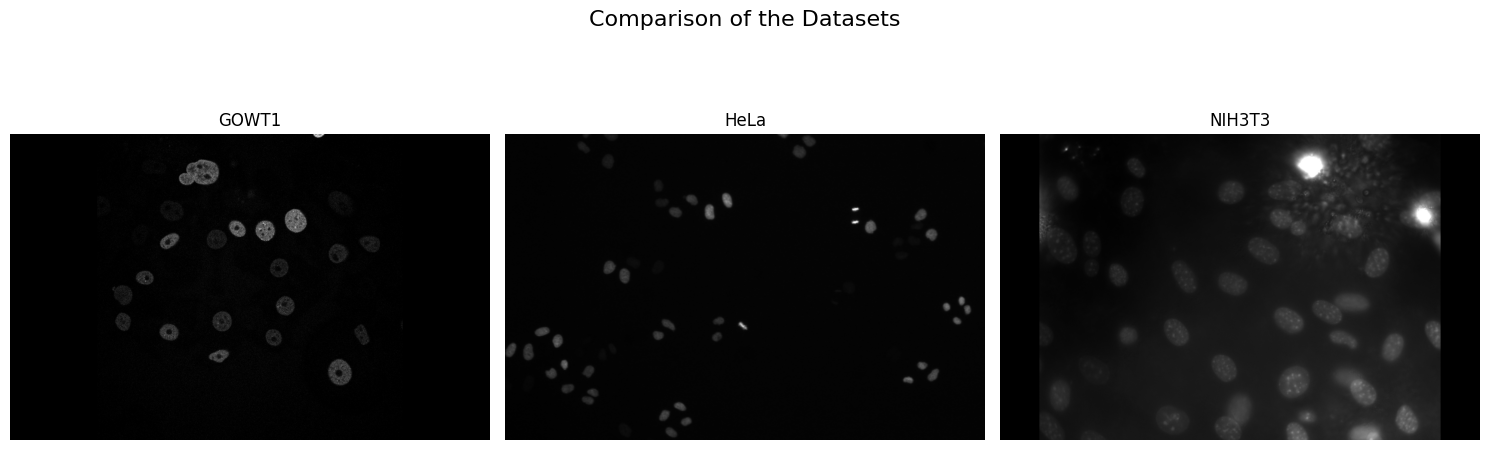

In [38]:
from src.find_image import find_and_load_image

img_gowt1 = find_and_load_image("t01.tif")
img_hela = find_and_load_image("t13.tif")
img_nih3t3 = find_and_load_image("dna-33.png")


from src.show_imgs import plot_images_fixed_size

images_img = [img_gowt1, img_hela, img_nih3t3]
titles_img = ["GOWT1", "HeLa", "NIH3T3"]

plot_images_fixed_size(images_img, titles=titles_img, main_title="Comparison of the Datasets")

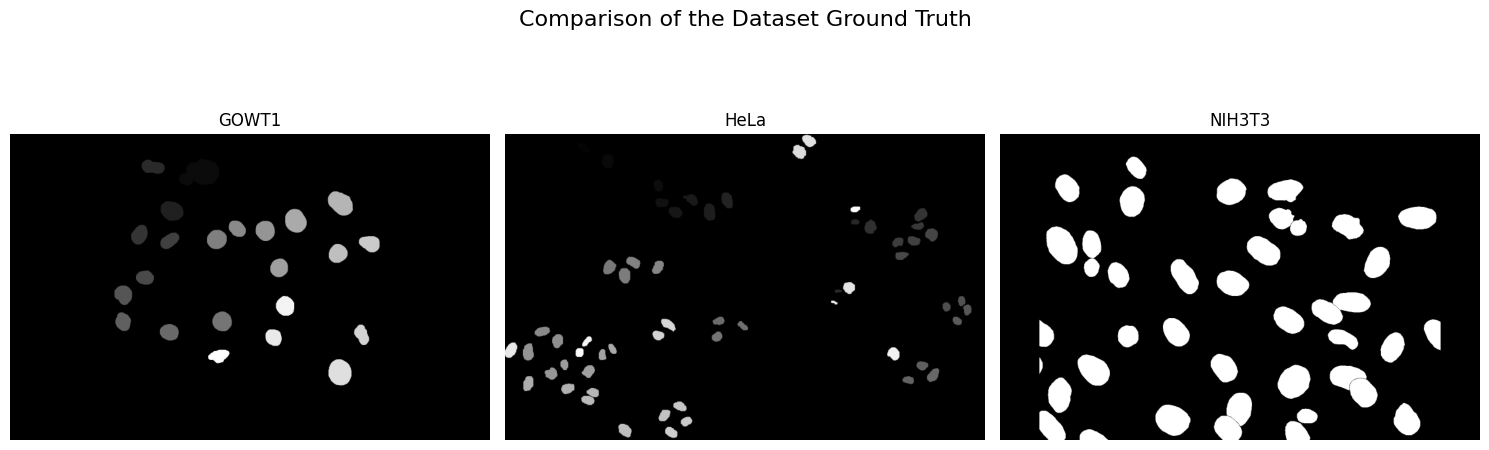

In [72]:
gt_gowt1 = find_and_load_image("man_seg01.tif")
gt_hela = find_and_load_image("man_seg13.tif")
gt_nih3t3 = find_and_load_image("33.png")


images_gt = [gt_gowt1, gt_hela, gt_nih3t3]
titles_gt = ["GOWT1", "HeLa", "NIH3T3"]

plot_images_fixed_size(images_gt, titles = titles_gt, main_title = "Comparison of the Dataset Ground Truth")

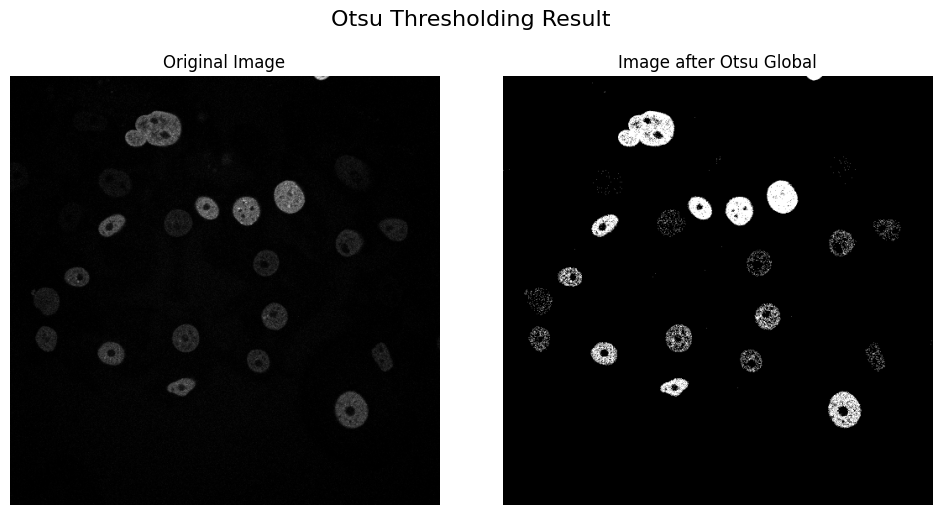

In [51]:
from src.Complete_Otsu_Global import otsu_threshold_skimage_like

threshold = otsu_threshold_skimage_like(img_gowt1)
img_gowt1_otsu_global = (img_gowt1 > threshold).astype(int)


plot_images_fixed_size(
    images=[img_gowt1, img_gowt1_otsu_global],
    titles=["Original Image", "Image after Otsu Global"],
    main_title="Otsu Thresholding Result"
)

Processing row 1/1024...
Processing row 51/1024...
Processing row 101/1024...
Processing row 151/1024...
Processing row 201/1024...
Processing row 251/1024...
Processing row 301/1024...
Processing row 351/1024...
Processing row 401/1024...
Processing row 451/1024...
Processing row 501/1024...
Processing row 551/1024...
Processing row 601/1024...
Processing row 651/1024...
Processing row 701/1024...
Processing row 751/1024...
Processing row 801/1024...
Processing row 851/1024...
Processing row 901/1024...
Processing row 951/1024...
Processing row 1001/1024...
Processing row 1024/1024...


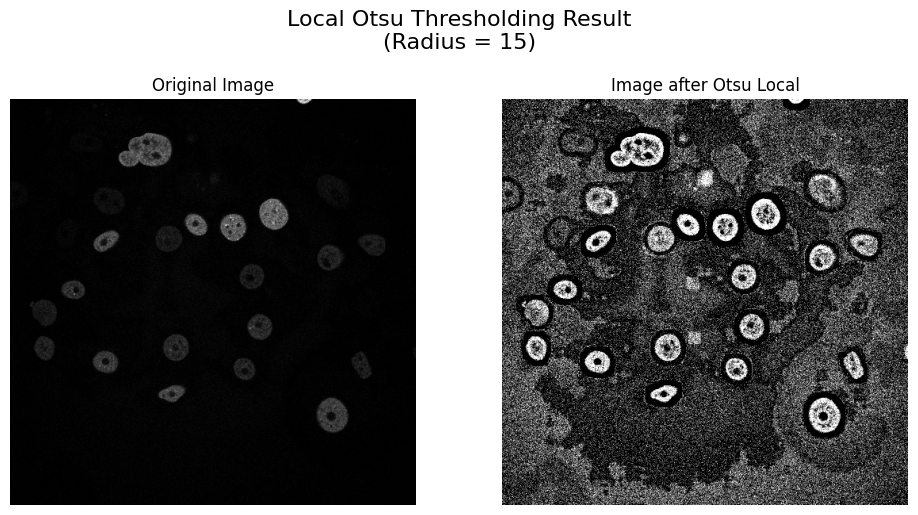

In [53]:
# takes very long

from src.Otsu_Local import local_otsu

thresholds_local = local_otsu(img_gowt1, radius = 15)
img_gowt1_otsu_local = (img_gowt1 > thresholds_local).astype(int)


plot_images_fixed_size(
    images=[img_gowt1, img_gowt1_otsu_local],
    titles=["Original Image", "Image after Otsu Local"],
    main_title="Local Otsu Thresholding Result\n(Radius = 15)"
)

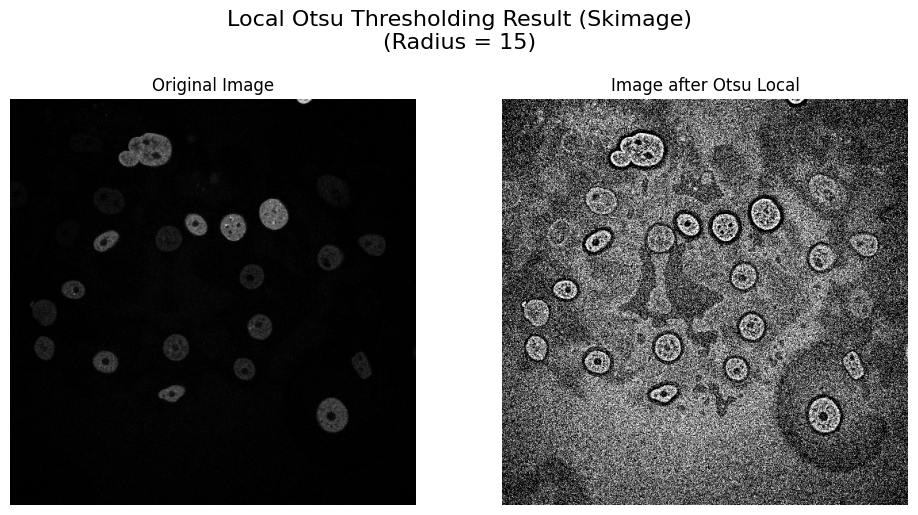

In [54]:
# Package Otsu Local for visualisation for time efficiency
from skimage.filters import threshold_local

thresholds_local = threshold_local(img_gowt1, block_size=31, offset=0)
img_gowt1_otsu_local_package = (img_gowt1 > thresholds_local).astype(int)


plot_images_fixed_size(
    images=[img_gowt1, img_gowt1_otsu_local_package],
    titles=["Original Image", "Image after Otsu Local"],
    main_title="Local Otsu Thresholding Result (Skimage)\n(Radius = 15)"
)

In [56]:
from src.Dice_Score import dice_score

dice_score_gowt1_global = dice_score(img_gowt1_otsu_global, gt_gowt1) 

dice_score_gowt1_local = dice_score(img_gowt1_otsu_local, gt_gowt1)

print("Dice Score Otsu Global:", dice_score_gowt1_global)
print("Dice Score Otsu Local:", dice_score_gowt1_local)

Dice Score Otsu Global: 0.06305886547523064
Dice Score Otsu Local: 0.078626262425266


In [57]:
# Imports from project-specific src/ directory
from src.imread_all import load_n2dh_gowt1_images, load_n2dl_hela_images, load_nih3t3_images


# Load images and ground-truth masks from the datasets
imgs_N2DH_GOWT1, gts_N2DH_GOWT1, img_paths_N2DH_GOWT1, gt_paths_N2DH_GOWT1 = load_n2dh_gowt1_images()
imgs_N2DL_HeLa, gts_N2DL_HeLa, img_paths_N2DL_HeLa, gt_paths_N2DL_HeLa = load_n2dl_hela_images()
imgs_NIH3T3, gts_NIH3T3, img_paths_NIH3T3, gt_paths_NIH3T3 = load_nih3t3_images()

In [71]:
from src.Dice_Score_comparison import calculate_dice_scores_global
#from src.Dice_Score_comparison import calculate_dice_scores_local

# Compute Dice scores for each dataset
dice_gowt1 = calculate_dice_scores_global(imgs_N2DH_GOWT1, gts_N2DH_GOWT1)
dice_hela = calculate_dice_scores_global(imgs_N2DL_HeLa, gts_N2DL_HeLa)
dice_nih = calculate_dice_scores_global(imgs_NIH3T3, gts_NIH3T3)

# Convert numpy floats to plain Python floats for clearer output
dice_gowt1 = [float(score) for score in dice_gowt1]
#dice_hela = [float(score) for score in dice_hela]
#dice_nih = [float(score) for score in dice_nih]

# Print scores in a readable format
print("GOWT1_Scores =", ", ".join(f"{score}" for score in dice_gowt1))
print("HeLa_Scores =", ", ".join(f"{score}" for score in dice_hela))
print("NIH3T3_Scores =", ", ".join(f"{score}" for score in dice_nih))

GOWT1_Scores = 0.5705017182130584, 0.32258217915948406, 0.568002229254991, 0.6271474725294504, 0.6502180828858916, 0.6615248976783192
HeLa_Scores = 0.6923060104510571, 0.649295517879001, 0.7760944676315427, 0.7761119912979735
NIH3T3_Scores = 0.9128436675562167, 0.8845252721173281, 0.8225479821936802, 0.758336987687637, 0.7528567225654604, 0.647632667167185, 0.6466958730507323, 0.7237186625334818, 0.03500481623642597, 0.46518566600901357, 0.0, 0.6762501531852865, 0.00026339009389856846, 0.5757554586315079, 0.6165448260228947, 0.07605520913993832, 0.07186834004262373, 0.7925039681767514
